## Principal Component Analysis

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
from IPython.display import display

from sklearn.preprocessing import StandardScaler
import scipy.stats as st

customers = pd.read_csv('Wholesale_customers_data.csv')
customers.Region = customers.Region.astype('category')
customers.Channel = customers.Channel.astype('category')
customer_features = customers.select_dtypes([int])

scaler = StandardScaler()
customer_sc = scaler.fit_transform(customer_features)
customer_sc_df = pd.DataFrame(customer_sc, columns=customer_features.columns)

customer_log_df = np.log(1+customer_features)
scaler.fit(customer_log_df)
customer_log_sc = scaler.transform(customer_log_df)
customer_log_sc_df = pd.DataFrame(customer_log_sc, columns=customer_features.columns)

customer_box_cox_df = pd.DataFrame()
for col in customer_features.columns:
    box_cox_trans = st.boxcox(customer_features[col])[0]
    customer_box_cox_df[col] = pd.Series(box_cox_trans)
    
scaler.fit(customer_box_cox_df)
customer_box_cox_sc = scaler.transform(customer_box_cox_df)
customer_box_cox_sc_df = pd.DataFrame(customer_box_cox_sc, columns=customer_features.columns)

In [2]:
def feature_outliers(dataframe, col, param=1.5):
    Q1 = np.percentile(dataframe[col], 25)
    Q3 = np.percentile(dataframe[col], 75)
    tukey_window = param*(Q3-Q1)
    less_than_Q1 = dataframe[col] < Q1 - tukey_window
    greater_than_Q3 = dataframe[col] > Q3 + tukey_window
    tukey_mask = (less_than_Q1 | greater_than_Q3)
    return dataframe[tukey_mask]

In [3]:
from collections import Counter

In [4]:
def multiple_outliers(dataframe, count=2):
    raw_outliers = []
    for col in dataframe:
        outlier_df = feature_outliers(dataframe, col)
        raw_outliers += list(outlier_df.index)

    outlier_count = Counter(raw_outliers)
    outliers = [k for k,v in outlier_count.items() if v >= count]
    return outliers

In [5]:
customer_features_outliers_removed = customer_features.drop(multiple_outliers(customer_features))
customer_sc_df_outliers_removed = customer_sc_df.drop(multiple_outliers(customer_sc_df))
customer_log_sc_df_outliers_removed = customer_log_sc_df.drop(multiple_outliers(customer_log_sc_df))
customer_box_cox_sc_df_outliers_removed = customer_box_cox_sc_df.drop(multiple_outliers(customer_box_cox_sc_df))

In [6]:
(customer_features.shape,
 customer_sc_df.shape,
 customer_log_sc_df.shape,
 customer_box_cox_sc_df.shape,
 customer_features_outliers_removed.shape,
 customer_sc_df_outliers_removed.shape,
 customer_log_sc_df_outliers_removed.shape,
 customer_box_cox_sc_df_outliers_removed.shape)

((440, 6),
 (440, 6),
 (440, 6),
 (440, 6),
 (399, 6),
 (399, 6),
 (435, 6),
 (438, 6))

In [7]:
from sklearn.decomposition import PCA

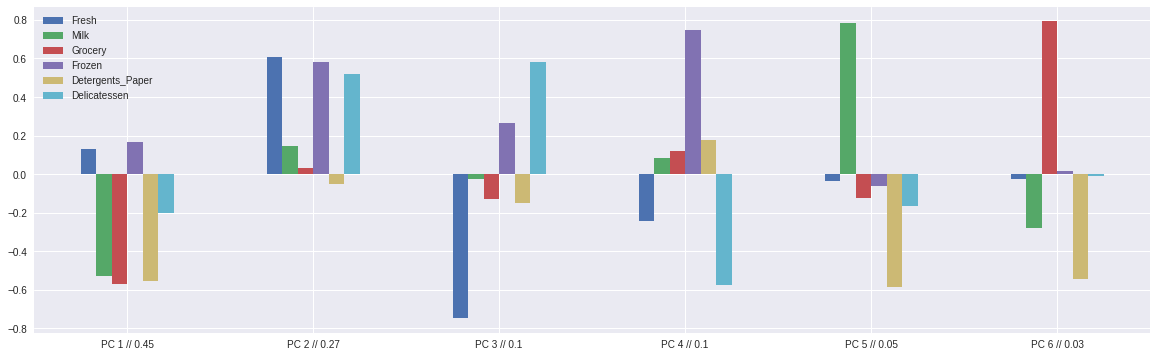

In [8]:
pca_box_cox = PCA()
pca_box_cox.fit(customer_box_cox_sc_df_outliers_removed)

principal_component_loadings_box_cox = \
 pd.DataFrame(pca_box_cox.components_, 
 columns=customer_box_cox_sc_df_outliers_removed.columns)

explained_variance_ratio_box_cox = pca_box_cox.explained_variance_ratio_
pca_labels_box_cox = ['PC ' + str(i+1) +' // ' + str(round(ratio,2)) for i, ratio in enumerate(explained_variance_ratio_box_cox)]

ax = principal_component_loadings_box_cox.plot(kind='bar', figsize=(20,6), rot=0)
ax.set_xticklabels(pca_labels_box_cox);

In [9]:
pca_log = PCA()
pca_log.fit(customer_log_sc_df_outliers_removed)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [10]:
principal_component_loadings_log = pd.DataFrame(pca_log.components_, columns=customer_log_sc_df_outliers_removed.columns)

In [11]:
explained_variance_ratio_log = pca_log.explained_variance_ratio_
pca_labels_log = ['PC ' + str(i+1) +' // ' + str(round(ratio,2)) for i, ratio in enumerate(explained_variance_ratio_log)]

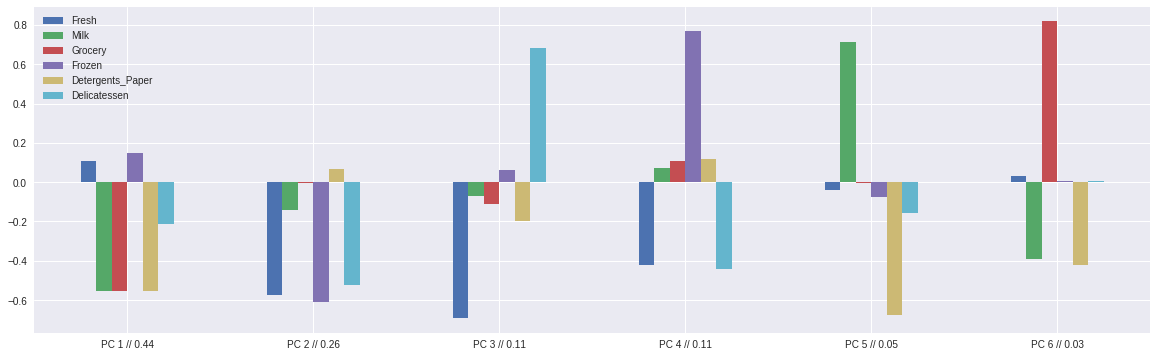

In [12]:
ax = principal_component_loadings_log.plot(kind='bar', figsize=(20,6), rot=0)
ax.set_xticklabels(pca_labels_log);

In [13]:
pca_orig = PCA()
pca_orig.fit(customer_features_outliers_removed)
pca_scaled = PCA()
pca_scaled.fit(customer_sc_df_outliers_removed)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [14]:
principal_component_loadings_orig = pd.DataFrame(pca_orig.components_, columns=customer_log_sc_df_outliers_removed.columns)
principal_component_loadings_scaled = pd.DataFrame(pca_scaled.components_, columns=customer_log_sc_df_outliers_removed.columns)

In [15]:
explained_variance_ratio_orig = pca_orig.explained_variance_ratio_
explained_variance_ratio_scaled = pca_scaled.explained_variance_ratio_
pca_labels_orig = ['PC ' + str(i+1) +' // ' + str(round(ratio,2)) for i, ratio in enumerate(explained_variance_ratio_orig)]
pca_labels_scaled = ['PC ' + str(i+1) +' // ' + str(round(ratio,2)) for i, ratio in enumerate(explained_variance_ratio_scaled)]

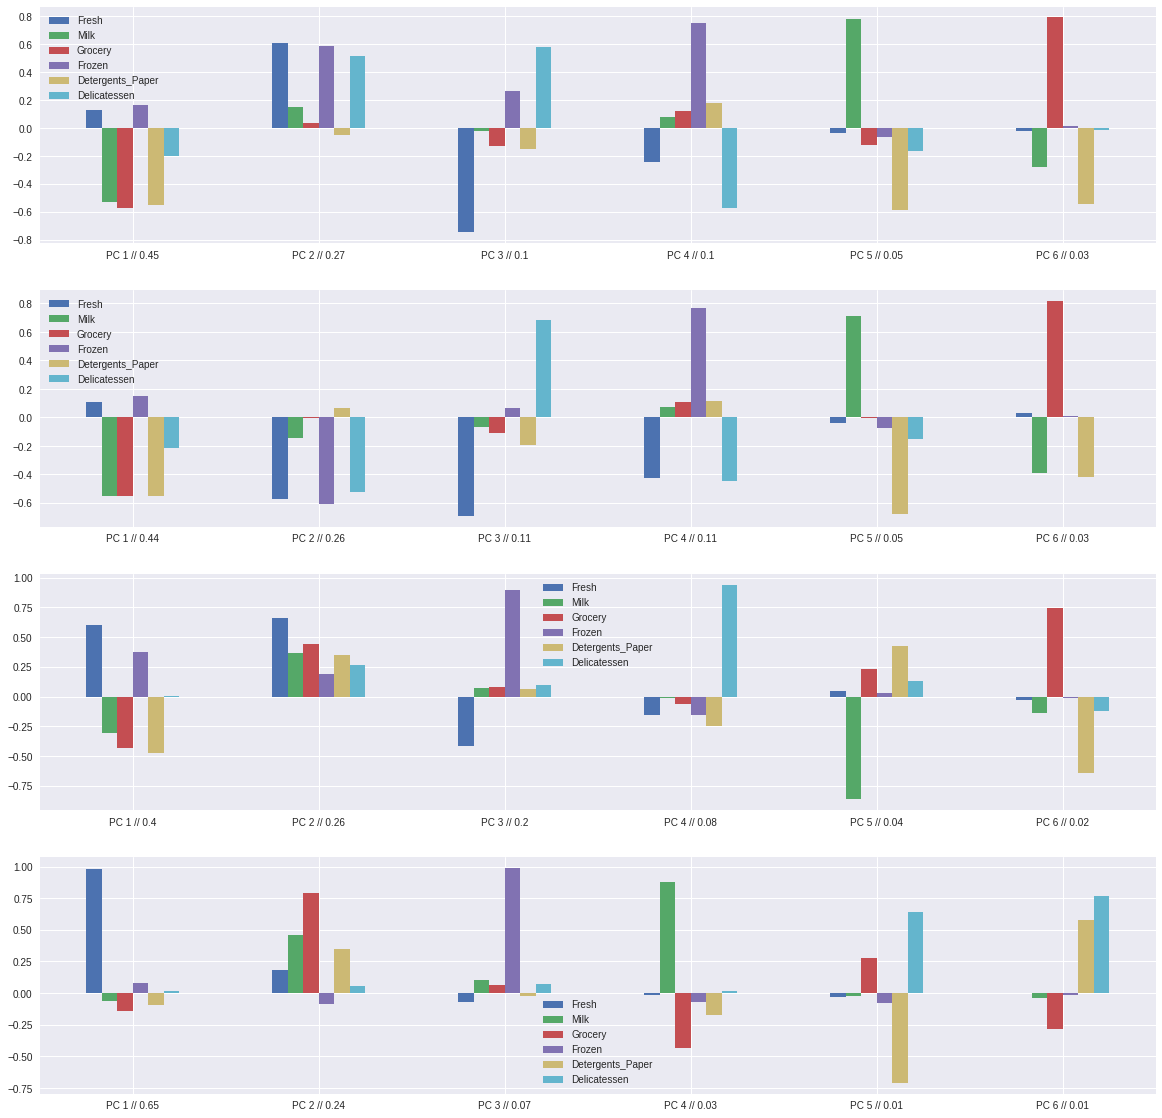

In [16]:
_, ax = plt.subplots(4,1,figsize=(20,20))
principal_component_loadings_box_cox.plot(kind='bar', rot=0, ax=ax[0])
ax[0].set_xticklabels(pca_labels_box_cox)
principal_component_loadings_log.plot(kind='bar', rot=0, ax=ax[1])
ax[1].set_xticklabels(pca_labels_log)
principal_component_loadings_scaled.plot(kind='bar', rot=0, ax=ax[2])
ax[2].set_xticklabels(pca_labels_scaled)
principal_component_loadings_orig.plot(kind='bar', rot=0, ax=ax[3])
ax[3].set_xticklabels(pca_labels_orig);

#### Scree Plot

Look for "the bend". This will tell you how many components to keep.

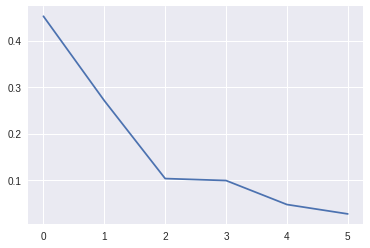

In [17]:
plt.plot(pca_box_cox.explained_variance_ratio_)

In [18]:
pca = PCA(2)
pca.fit(customer_box_cox_sc_df_outliers_removed)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [19]:
sample = customer_box_cox_sc_df_outliers_removed.sample(5)

In [20]:
customer_pca_df = pd.DataFrame(pca.transform(customer_box_cox_sc_df), 
                               columns=['Dim 1', 'Dim 2'],
                               index=customer_box_cox_sc_df.index)
sample_pca_df = pd.DataFrame(pca.transform(sample), 
                             columns=['Dim 1', 'Dim 2'],
                             index=sample.index)

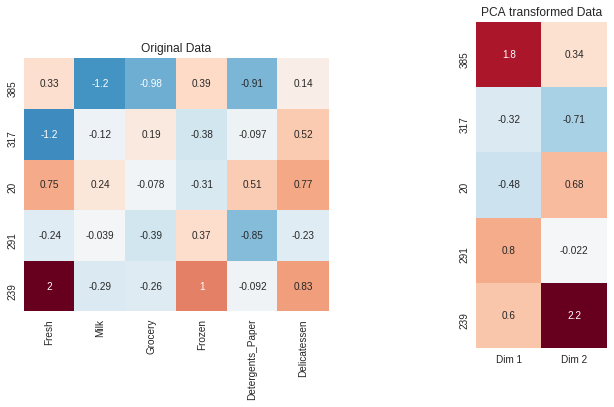

In [21]:
fig = plt.figure(figsize=(12,6))
fig.add_subplot(121)
plt.title("Original Data")
sns.heatmap(sample, annot=True, cbar=False, square=True)
fig.add_subplot(122)
plt.title("PCA transformed Data")
sns.heatmap(sample_pca_df, annot=True, cbar=False, square=True)

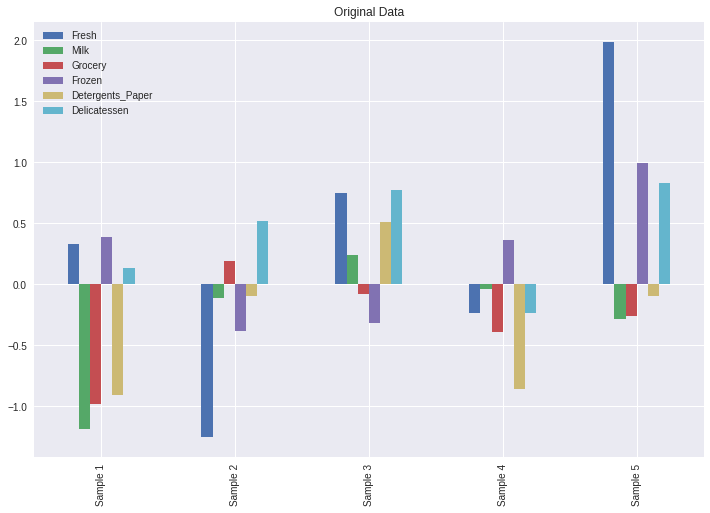

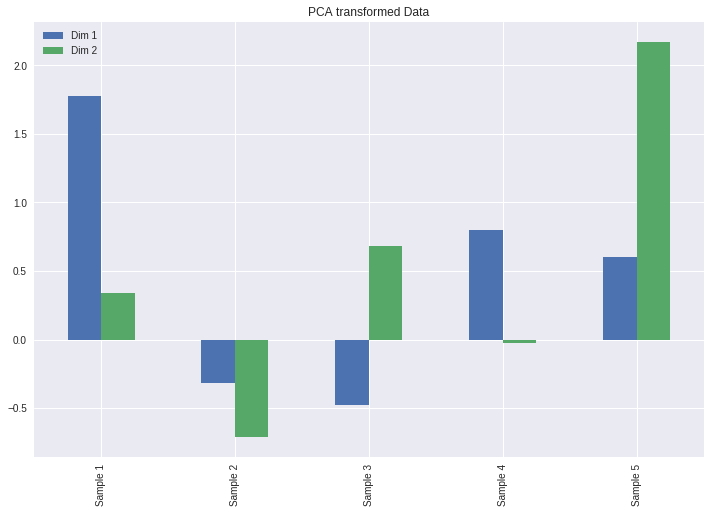

In [22]:
sample.plot(kind='bar', figsize=(12,8))
plt.title("Original Data")
_ = plt.xticks(range(5),['Sample 1','Sample 2','Sample 3', 'Sample 4','Sample 5'])

sample_pca_df.plot(kind='bar', figsize=(12,8))
plt.title("PCA transformed Data")
_ = plt.xticks(range(5),['Sample 1','Sample 2','Sample 3', 'Sample 4','Sample 5'])